In [18]:
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# runtime imports
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import Aer

# to map the circuit to the backend isa
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Visualization
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector

# 1. Setting up the Hamiltonian

In [19]:
hamiltonian = SparsePauliOp.from_list(
    [("XX", 1), ("YY", 1), ("ZI", 1)]
)

# 2. Choosing the Ansatz
- I am using `EfficientSU2` that, by default, linearly entangles qubits, making it ideal for quantum hardware with limited connectivity.

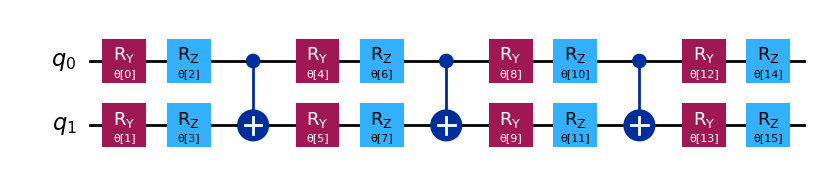

In [20]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
num_params = ansatz.num_parameters
ansatz.decompose().draw("mpl")

# 3. Execute using Qiskit Primitives

In [21]:
backend = Aer.get_backend('aer_simulator')

In [22]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [23]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specify a random initial set of parameters:


In [24]:
x0 = 2 * np.pi * np.random.random(num_params)

In [25]:
x0

array([4.93496135, 0.97152667, 1.57339554, 4.11414787, 4.18273568,
       1.19031285, 6.16960474, 2.26839399, 3.97296404, 5.27133564,
       4.39306276, 4.9360154 , 2.35963147, 6.05192551, 1.65143102,
       2.56735853])

Because we are sending a large number of jobs that we would like to execute together, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.


# Finally running the VQE, following a mapping to the simulator ISA 

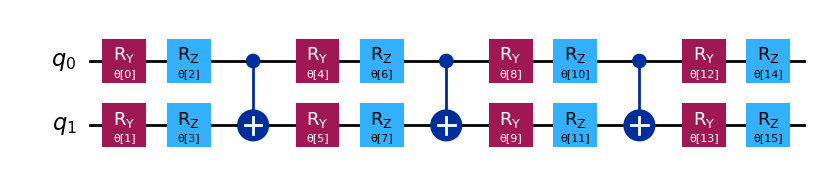

In [26]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
ansatz_isa.draw("mpl")

In [27]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.32980000000000004]
Iters. done: 2 [Current cost: -1.035]
Iters. done: 3 [Current cost: -1.0806]
Iters. done: 4 [Current cost: -0.7664]
Iters. done: 5 [Current cost: -0.9444]
Iters. done: 6 [Current cost: -0.9836]
Iters. done: 7 [Current cost: -1.1488]
Iters. done: 8 [Current cost: -0.2198]
Iters. done: 9 [Current cost: -0.9984000000000001]
Iters. done: 10 [Current cost: -0.5502]
Iters. done: 11 [Current cost: -0.4905999999999999]
Iters. done: 12 [Current cost: -1.3641999999999999]
Iters. done: 13 [Current cost: -1.2314]
Iters. done: 14 [Current cost: -1.8472]
Iters. done: 15 [Current cost: -1.4856]
Iters. done: 16 [Current cost: -1.4374000000000002]
Iters. done: 17 [Current cost: -1.1865999999999999]
Iters. done: 18 [Current cost: -1.3780000000000001]
Iters. done: 19 [Current cost: -1.2522]
Iters. done: 20 [Current cost: -1.8148]
Iters. done: 21 [Current cost: -1.9142]
Iters. done: 22 [Current cost: -2.0694]
Iters. done: 23 [Current cost: -2.0386]
Iters

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.


In [28]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2024
       x: [ 5.877e+00  2.077e+00 ...  1.771e+00  2.497e+00]
    nfev: 164
   maxcv: 0.0

In [29]:
ansatz_isa_params = ansatz_isa.assign_parameters(res.x)
ansatz_isa_params.save_statevector()
resulting_eigenstate_1 = backend.run(ansatz_isa_params).result().get_statevector()

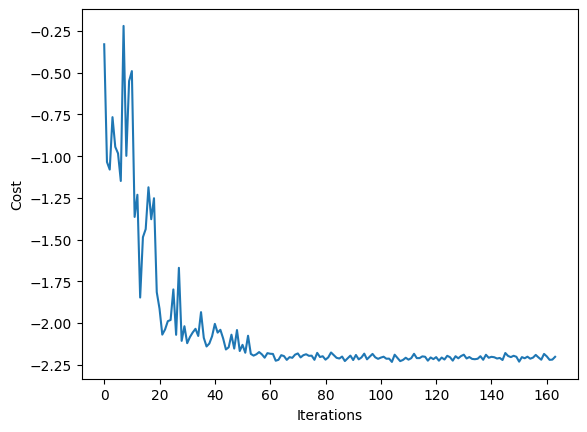

In [30]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()
plt.show()

# Qiskit NumPyMinimumEigensolver

In [31]:
from qiskit_algorithms import NumPyMinimumEigensolver
solver = NumPyMinimumEigensolver()
result = solver.compute_minimum_eigenvalue(hamiltonian)

# Results

## 1. Scipy solver with a 16 parameter ansatz

The minimum eignevalue obtained is -2.2024, with the following eigenstate:


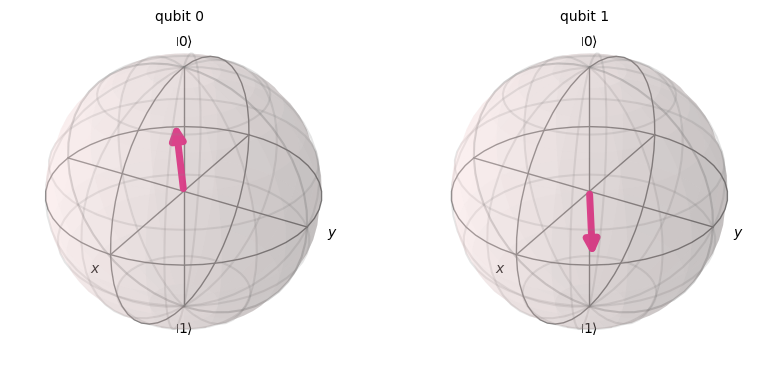

In [32]:
print(f"The minimum eignevalue obtained is {res.fun}, with the following eigenstate:")
plot_bloch_multivector(resulting_eigenstate_1)

## 2. NumPyMinimumEigensolver

The minimum eignevalue obtained by NumPyMinimumEigensolver is -2.2360679774997854, with the following eigenstate:


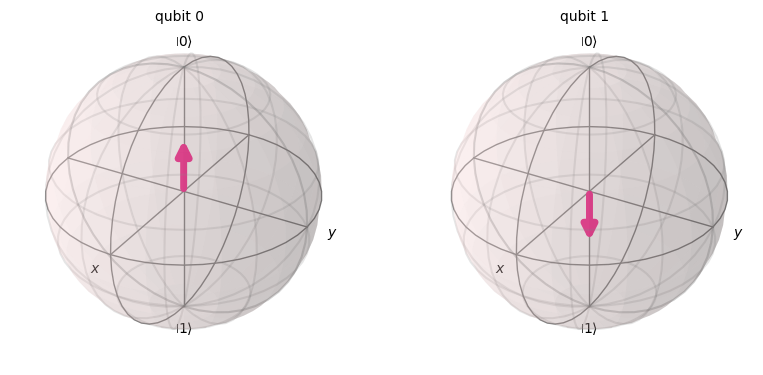

In [33]:
print(f"The minimum eignevalue obtained by NumPyMinimumEigensolver is {result.eigenvalue}, with the following eigenstate:")
plot_bloch_multivector(result.eigenstate)